<a href="https://colab.research.google.com/github/Weizhuo-Zhang/ML_coursera/blob/master/sml_workshop/worksheet02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP90051 Workshop 2
## Bayesian inference

***



### 0. Preamble
In situations where we have incomplete knowledge of the environment, we can represent the uncertainty in our knowledge by a joint probability distribution over variables whose values are known (_observed variables_) and unknown variables (_hidden or latent variables_). _Bayesian inference_ is the process through which we infer the values of the latent variables from values of the observed variables via some model of the data-generating process. Note that the hidden variables include our model parameters, which reflect uncertainty in our choice of model.

In this part of the workshop, we'll develop some intuition for priors and posteriors, which are crucial to Bayesian inference.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import seaborn as sns
sns.set_style('darkgrid')

from scipy.stats import bernoulli, beta

### 1. A lucky find

On the way to class, you discover an unusual coin on the ground.

<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/1_2_penny_Middlesex_DukeYork_1795_1ar85_%288737903267%29.jpg" alt="Coin" width="350"/>

As a dedicated student in statistical ML, you're interested in determining whether the coin is biased. We will write $x_n = 1$ on flip $n$ if the result comes up heads and $x_n = 0$ if tails.
More specifically, you want to estimate the probability $p(x_n = 1 \vert \theta) = \theta$ that the coin will land heads-up when you toss it. For a fair coin, $\theta = 1/2$. (The coin’s ‘bias’ should not be confused with the two homonyms: a point estimate’s bias; or the bias/intercept weight of a linear model.)

You can use the function below to simulate a coin toss: it returns `1` for heads and `0` for tails.

In [0]:
def toss_coin():
    if bernoulli.rvs(p = (int.from_bytes("coin".encode(), 'little') % 10000)/10000):
        return 1
    return 0

### 2. Prior belief
Before you even toss the coin, you notice that the heads side appears to have more mass. 
Thus, your _prior belief_ is that $\theta$ is slightly biased away from 0.5 towards 0—i.e. you expect tails are more likely.

To quantify this prior belief, we assume that the prior distribution for $\theta$ is $\mathrm{Beta}(a,b)$, for some choice of the hyperparameters $a, b > 0$.
The Beta distribution is a flexible modelling choice for random variables between $0$ and $1$. Because of this, it is commonly used to model a _distribution over probabilities_ - in this case, the probability of heads (see [link](https://en.wikipedia.org/wiki/Beta_distribution) for info about the Beta distribution).
The prior probability density function for $\theta$ is therefore given by:

#### $$ p(\theta) = \frac{1}{B(a,b)} \theta^{a-1} (1 - \theta)^{b-1} $$
where $B(a,b)$ is a special function called the _Beta function_. This constant (given some choice of hyperparameters $a,b$) ensures proper normalization of the probability density function. We will sometimes say that we are modelling the variable $\theta$ _as distributed according to the Beta distribution_ and write $\theta \sim \mathrm{Beta}(a,b)$.

Select appropriate values for $a$ and $b$ by adjusting the plot of $p(\theta)$ below to match your initial expectations.

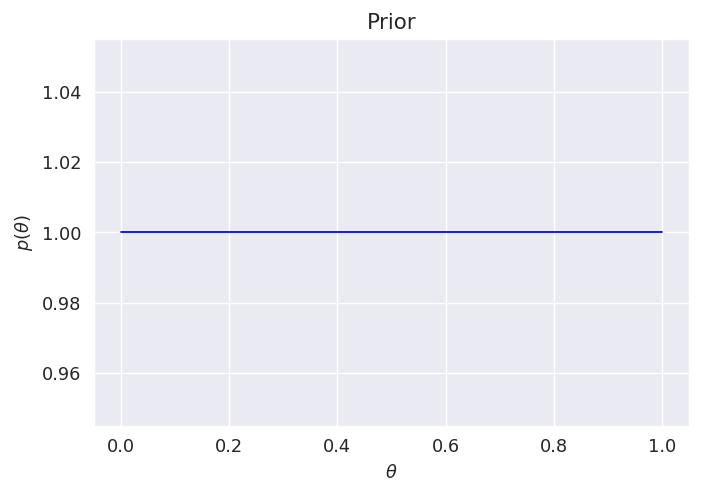

In [0]:
a = 1 # fill in
b = 1 # fill in
theta = np.linspace(0, 1, 1000)

FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

plt.plot(theta, beta.pdf(theta, a, b), 'b-', lw=1)
plt.title('Prior')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.show()

### 3. Posterior updates
Now toss the coin once and denote the outcome by $x_1$. This is our _observed data_ so far.

In [0]:
x1 = toss_coin()
print(x1)

0


We can update our belief about $\theta$, based on this new evidence $x_1$.
To do this we apply Bayes' rule to compute the posterior for $\theta$:
#### $$ p(\theta | x_1) = \frac{p(x_1 | \theta) \, p(\theta)}{p(x_1)} \propto p(x_1 | \theta) \, p(\theta)$$
where $p(\theta)$ is the prior given above and 
#### $$ p(x_1 | \theta) = \theta^{x_1} (1 - \theta)^{1 - x_1} $$
is the likelihood, which gives the conditional probability of the observed data $x_n$ given some fixed $\theta$.

***
**Exercise:** Show (on paper) that the posterior takes the form of a Beta distribution.
#### $$\theta | x_1 \sim \mathrm{Beta}[x_1 + a, (1 - x_1) + b]$$

If the posterior and prior have the same function form, we say that the prior (in this case Beta) is _conjugate_ to the likelihood function (in this case Bernoulli). This is convenient because the prior and posterior distributions have the same functional form, which admits a closed form expression for all posterior updates. This also allows us to ignore constant factors in intermediate calculations, as we may recover the normalizing factors by comparison with the standard form of the relevant density for the posterior.

[Hint: a similar calculation was performed in L2, slide 20 for the case of a normal prior and posterior.]

<!-- Hint: Show $ p(\theta | x_1) \propto \theta^{x_1 + a - 1} (1 - \theta)^{(1 - x_1) + b - 1} $. -->
***

Toss the coin a second time, denoting the outcome by $x_2$.

In [0]:
x2 = toss_coin()
print(x2)

1


Again, we want to update our belief about $\theta$ based on the new information $x_2$. 
We take the previous posterior $p(\theta|x_1)$ as the new prior and apply Bayes' rule:
#### $$ p(\theta | x_1, x_2) \propto p(x_2 | \theta) p(\theta | x_1)$$
\[Note I: We assume the tosses are independent, otherwise the likelihood for $x_2$ would depend on $x_1$.\] 
This gives $\theta | x_1, x_2 \sim \mathrm{Beta}[x_1 + x_2 + a, (2 - x_1 - x_2) + b]$.

\[Note II: It is not obvious why we can treat the previous posterior as our current prior. Interested students may refer to the bottom of the notebook for a brief justification.]

***
**Exercise:** Show that for $N$ coin tosses, the posterior $p(\theta | x_1, \ldots, x_N) = \operatorname{Beta}[N_H + a, N - N_H + b]$ where $N_H = \sum_{n = 1}^{N} x_n$ is the number of heads observed.
***

### 4. MAP estimator and MLE estimator

The posterior $\theta|x_1, \ldots, x_N$ contains all the information we know about $\theta$ after observing $N$ coin tosses.
One way of obtaining a point estimate of $\theta$ from the posterior, is to take the value with the maximum a posteriori probability (MAP):

\begin{align}
    \hat{\theta}_{MAP} &= \arg \max_{\theta} p(\theta|x_1, \ldots, x_N) \\
        &= \frac{N_H + a - 1}{N + a + b - 2}
\end{align}

In general, the MAP estimator gives a different result to the maximum likelihood estimator (MLE) for $\theta$:

\begin{align}
    \hat{\theta}_{MLE} &=\arg \max_{\theta} p(x_1, \ldots, x_N|\theta) \\
        &= \frac{N_H}{N}
\end{align}

***
**Exercise:** Derive the above results for $\hat{\theta}_{MAP}$ and  $\hat{\theta}_{MLE}$. Give the condition for the estimators to be (exactly) equal, i.e. $\hat{\theta}_{MAP} = \hat{\theta}_{MLE}$. What is the prior in this case?
***

### 5. Convergence of the estimates

Let's now toss the coin an additional 48 times (so that $N = 50$), recording $\hat{\theta}_{MLE}$ and $\hat{\theta}_{MAP}$ after each toss.

In [0]:
extra_tosses = 48
num_tosses = 2 + extra_tosses
num_heads = 0
theta_map = np.zeros(num_tosses)
theta_mle = np.zeros(num_tosses)
for i in range(1, num_tosses):
    if i == 1: 
        num_heads += x1 
    elif i == 2:
        num_heads += x2
    else:
        num_heads += toss_coin()
    theta_map[i] = (num_heads + a - 1) / (num_tosses + a + b - 2) # fill in
    theta_mle[i] = num_heads / num_tosses# fill in
    
theta_map = theta_map[1:]
theta_mle = theta_mle[1:]

We plot the results below.

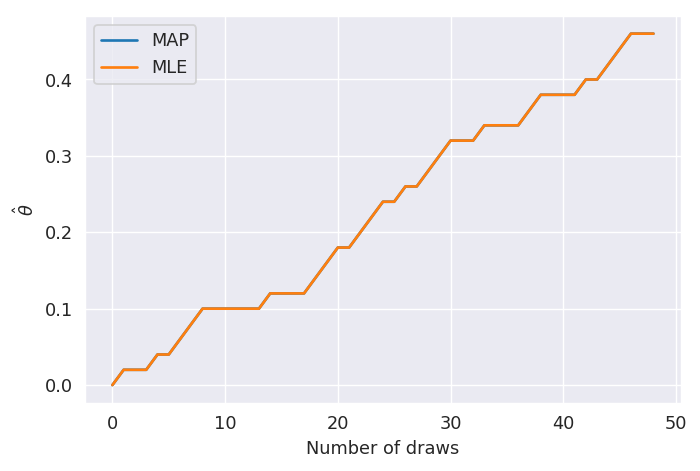

In [0]:
plt.plot(theta_map, label = "MAP")
plt.plot(theta_mle, label = "MLE")
plt.xlabel('Number of draws')
plt.ylabel(r'$\hat{\theta}$')
plt.legend()
plt.show()

**Questions:** 

1. Is the coin biased?
1. Do the MAP and MLE estimates converge to the same value for $\theta$?
1. What happens if you set $a = 1; b = 1$?
1. How does the posterior distribution for $\theta$ compare to the prior plotted above? (Use the code block below to plot the posterior.)

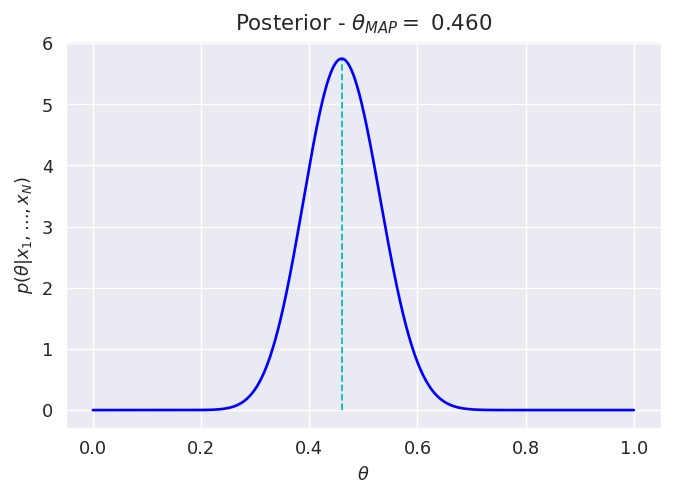

In [0]:
beta_pdf = beta.pdf(theta, a + num_heads, b + num_tosses - num_heads)
theta_map = theta[beta_pdf.argmax()]
plt.plot(theta, beta_pdf, 'b-', lw=1.5)
plt.title(r'Posterior - $\theta_{MAP} =$' + ' ${:.3f}$'.format(theta_map))
plt.xlabel(r'$\theta$')
plt.vlines(x=theta_map, ymin=0, ymax=beta_pdf.max(), linestyle='--', color='c', lw=1)
plt.ylabel(r'$p(\theta|x_1, \ldots, x_N)$')
plt.show()

Finally, we'll visualize the evolution of the posterior distribution as we observe more data. Before running the code cell below, take a couple of minutes to discuss with those around you how you expect the posterior to behave qualitatively) as the number of observed samples $x_n$ increases.

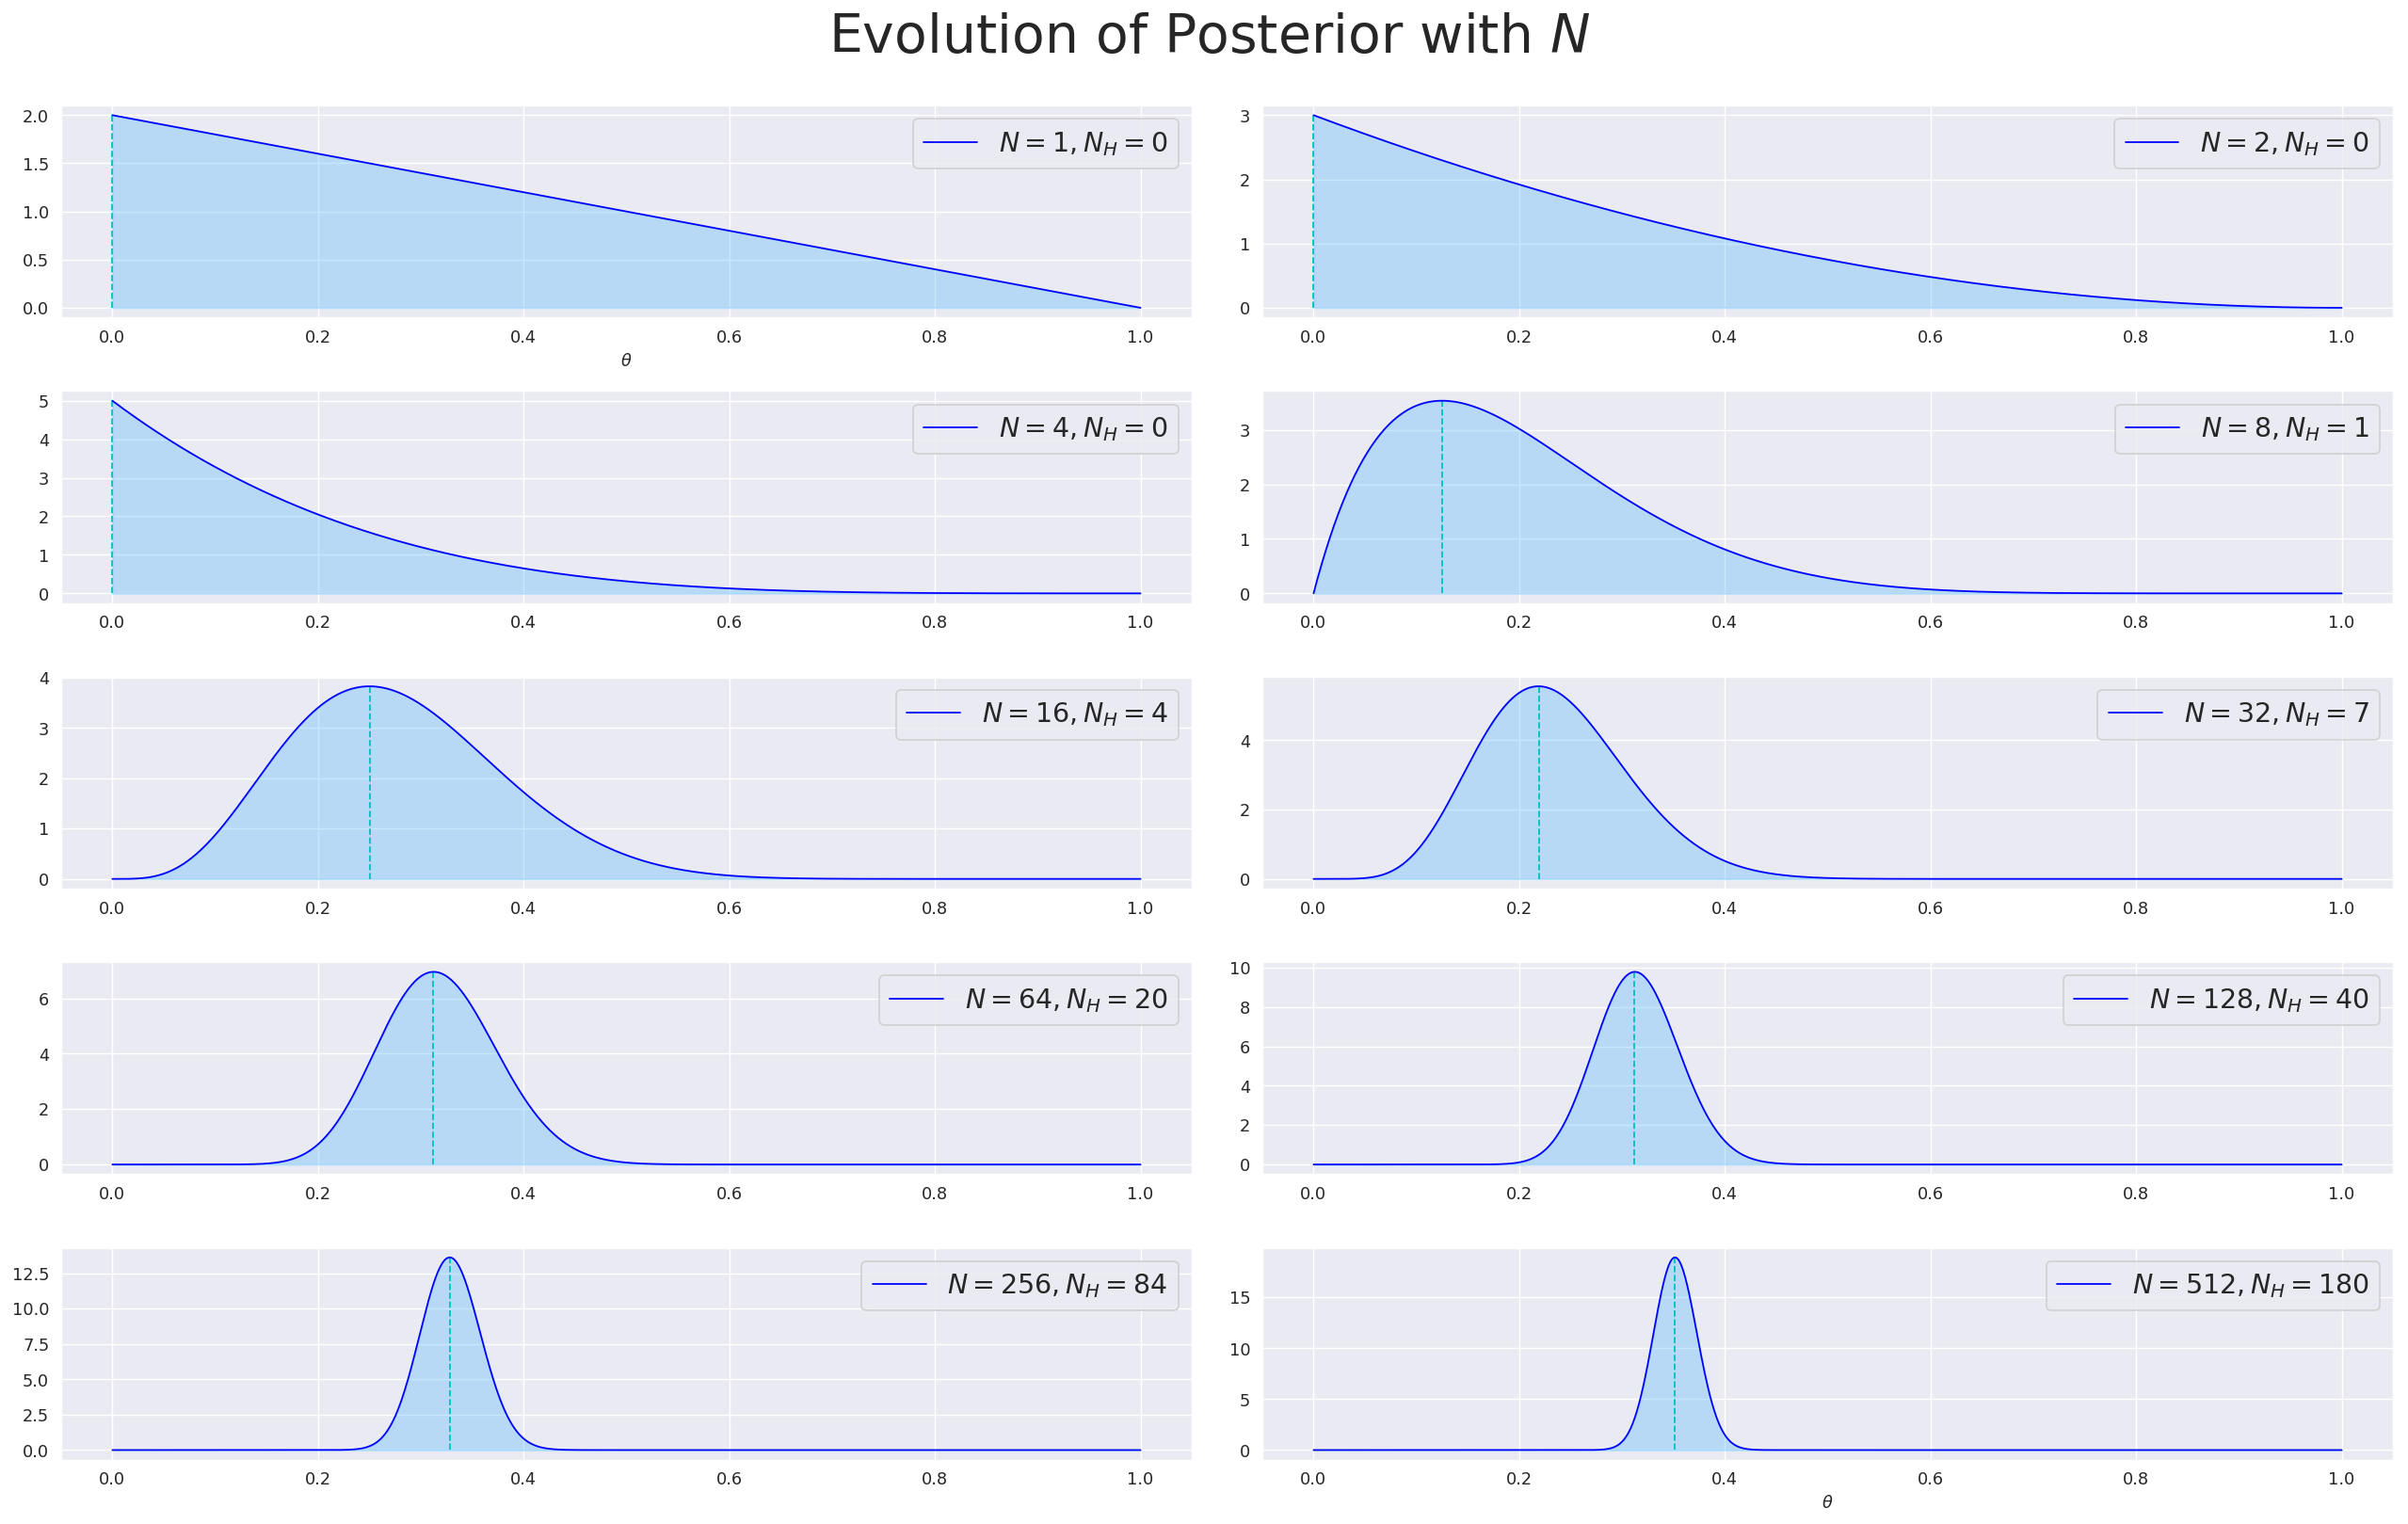

In [0]:
samples = [1,2,4,8,16,32,64,128,256,512]
flips = np.array([toss_coin() for _ in range(samples[-1])])
nice_shade = "#4cb6ff"

plt.figure(figsize=(20,12))

for i, N in enumerate(samples):
    sub = plt.subplot(len(samples)//2, 2, i+1)
    N_H = flips[:N].sum()
    beta_pdf_N = beta.pdf(theta, a + N_H, b + N - N_H)
    theta_map = theta[beta_pdf_N.argmax()]
    plt.plot(theta, beta_pdf_N, 'b-', lw=1, label=r'$N = {}, N_H = {}$'.format(N, N_H))
    if i in [0, len(samples)-1]:
        plt.xlabel(r'$\theta$') 
    plt.fill_between(theta, 0, beta_pdf_N, color=nice_shade, alpha=0.314)
    plt.vlines(x=theta_map, ymin=0, ymax=beta_pdf_N.max(), linestyle='--', color='c', lw=1)
    plt.legend(fontsize=16)
    plt.autoscale()
    
plt.suptitle('Evolution of Posterior with $N$', y=1.05, fontsize=32)
plt.tight_layout()

We should expect the posterior to concentrate as we increase the number of observed samples, and it does! Initially we have a high degree of uncertainty about the value of the hidden variable $\theta$. In this simple situation, as we observe more data, we grow increasingly confident of the value of $\theta$, reflected in the tightening of the posterior around $\hat{\theta}_{MAP}$. (Note that the scale on each graph is different).

### Bonus
In principle, the posterior distribution contains all the information about the possible values of the parameter $\theta$. To show the utility of the posterior, we can obtain a quantitative measure of the posterior uncertainty by computing a central (or equal-tailed) interval of posterior probability. These are known as _Bayesian credible intervals_ and should not be confused with the frequentist concept of _confidence intervals_ which leverage the distribution of point estimators. For a Bayesian credible interval, an e.g. $95\%$ credible interval contains the true parameter value with $95\%$ probability. In general, for a $1- \alpha$ interval, where $\alpha \in (0,1)$, this corresponds to the range of values $I = (\theta_1, \theta_2)$ above and below which lie exactly $\alpha/2$ of the posterior probability. That is, $\alpha/2$ of the probability mass of the posterior lies below $\theta_1$, and $\alpha/2$ of the probability mass lies above $\theta_2$.

In [0]:
alpha = 0.05  # define the confidence level
posterior = beta(a + num_heads, b + num_tosses - num_heads)  # define the posterior
theta_1, theta_2 = posterior.ppf([alpha/2., 1-alpha/2.])  # Inverse of the CDF - returns relevant quantiles

We should check that $1-\alpha$ of the probability mass actually lies inside our computed interval. That is, we expect 
#### $$ \int_{\theta_1}^{\theta_2} d \theta \; p(\theta \vert x_1, \ldots x_n) = 1-\alpha $$

In [0]:
integrate.quad(lambda theta: posterior.pdf(theta), a=theta_1, b=theta_2)  # second return value gives absolute error in integral

(0.9500000000000011, 1.6429897824788424e-13)

Looks good! What does this interval look like?

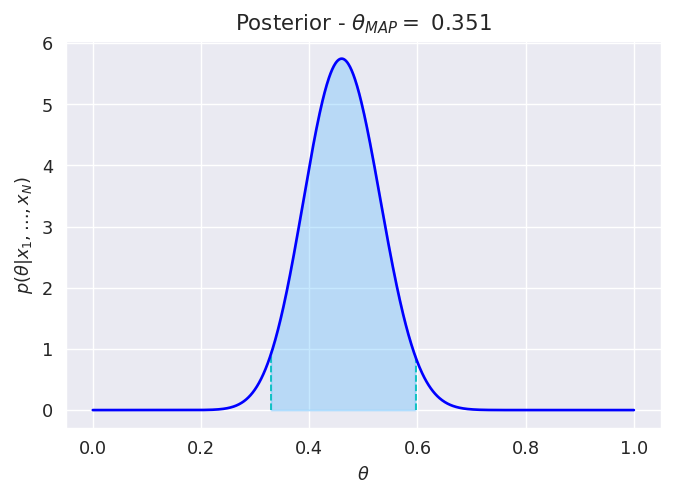

In [0]:
plt.plot(theta, beta_pdf, 'b-', lw=1.5)
plt.title(r'Posterior - $\theta_{MAP} =$' + ' ${:.3f}$'.format(theta_map))
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta|x_1, \ldots, x_N)$')
plt.vlines(x=theta_1, ymin=0, ymax=posterior.pdf(theta_1), linestyle='--', color='c', lw=1)
plt.vlines(x=theta_2, ymin=0, ymax=posterior.pdf(theta_2), linestyle='--', color='c', lw=1)
plt.fill_between(theta, beta_pdf, 0, where=(theta > theta_1) & (theta < theta_2), color=nice_shade, alpha=0.314)
plt.show()

**Exercise:** Remember that a conjugate prior for a likelihood function is one where the posterior distribution has the same functional form as the prior. You have seen two examples previously. The first was a normal prior on the mean of a normal distribution being conjugate to a normal likelihood (Lecture 2, slide 20) and the second is the Beta prior with Bernoulli likelihood shown above. The _inverse Gamma_ distribution is a distribution over positive numbers with the following probability density function for some choice of hyperparameters $\alpha, \beta$:
   $$ p(z) = \frac{\beta^\alpha}{\Gamma(\alpha)} z^{-(\alpha + 1)} \exp \left(-\frac{\beta}{z}\right) $$
Where $\Gamma(\cdot)$ is the Gamma function. To simplify notation, we will write $z \sim \mathrm{IG}(\alpha, \beta)$. As before, the constant factors ensure normalization of the density to one. The inverse Gamma distribution may be used as a prior on the variance of a normal distribution, as we shall see below.

Assume we obtain $n$ observations from a Gaussian with fixed mean $\mu$ and unknown variance $\sigma^2$, i.e. $x^{(i)} \sim \mathcal{N}(\mu, \sigma^2)$ and we place an inverse Gamma prior $p(\sigma^2)$ with hyperparameters $\alpha, \beta$ over the variance. Show that the posterior takes the form of the following inverse Gamma distribution.

   $$ p(\sigma^2 \vert x_1, \ldots x_n) = \mathrm{IG}\left(\alpha + \frac{n}{2}, \; \beta + \frac{1}{2} \sum_i \left( x^{(i)} - \mu\right)^2\right) $$

[Hint I: Drop constant factors from your intermediate calculations and show that the posterior matches the functional form of an inverse Gamma distribution. The normalizing constants may be recovered by comparison with the standard IG PDF.] 

[Hint II: You may find it easier to start with the $n=1$ case and generalize from there.]

### A. Justifying the sequential Bayesian update rule (optional reading)

Here we briefly justify why we are allowed to use the previous posterior as our current prior when observing a sequence of independent observations $\mathbf{x}_t = (x_1, x_2, \ldots x_t)$. This is useful in any situation where we would like to update our belief state as we acquire new information over time, e.g. speech recognition and robotic sensing.

The _likelihood_ function expresses the probability of the observed data sequence $\mathbf{x}_t$ given the hidden parameter random variable $\theta$, which we would like to infer.

#### $$p(\mathbf{x}_t \vert \theta) = p(x_1, \ldots x_t \vert \theta) = p(x_1 \vert \theta) p(x_2 \vert x_1, \theta) \ldots p(x_t \vert \mathbf{x}_{t-1}, \theta) $$ 

We can apply Bayes' Theorem to find the posterior at time $t$ (up to some normalization):

#### $$ p(\theta \vert \mathbf{x}_t) \propto p(\mathbf{x}_t \vert \theta) p(\theta) $$

We would like to relate this to the posterior at time $t+1$: $p(\theta \vert \mathbf{x}_{t+1})$, we may use the chain rule to accomplish this:

#### $$ p(\theta \vert \mathbf{x}_{t+1}) \propto p(\mathbf{x}_{t+1} \vert \theta) p(\theta) = p(x_{t+1} \vert \mathbf{x}_t, \theta) p(\mathbf{x}_t \vert \theta) p(\theta)$$

The proportionality is due to Bayes' Theorem and the equality is due to the chain rule of probability. Now we apply Bayes' Theorem a second time ($p(\theta \vert \mathbf{x}_t) \propto p(\mathbf{x}_t \vert \theta) p(\theta)$) to obtain:

#### $$ p(\theta \vert \mathbf{x}_{t+1}) \propto p(x_{t+1} \vert \mathbf{x}_t, \theta) p(\theta \vert \mathbf{x}_t) = p(x_{t+1} \vert \theta) p(\theta \vert \mathbf{x}_t) $$

Where the equality is due to our assumption that measurements are conditionally independent given the parameter $\theta$. Hence the posterior at time $t+1$ is product of the likelihood at time $t+1$ and the posterior at time $t$ up to normalization.

### B. Further Reading
Interested students may wish to consult Chapter 1.2 and 2.1 of _Bishop, Pattern Recognition and Machine Learning (2007)_ for a refresher on probability and some discussion of the Beta and Bernoulli distributions in the context of inference. 